# Preprocess Data

In [1]:
import numpy as np
import torch
import glob2
from torch.utils.data import Dataset
import random
import nltk
import string
from nltk.util import ngrams
from collections import Counter
import pickle as pkl

In [2]:
def read_data(paths, label):
    data=[]
    labels=[]
    
    for path in glob2.glob(paths):
        file = open(path, "r")
        data.append(file.read())
        
        labels.append(label)
        file.close() 
        
    return data, labels

In [3]:
local_dir = '/Users/wyz0214/Downloads/1011_a1/aclImdb/'
train_data_pos, train_label_pos = read_data(local_dir+"train/pos/*", 1)
train_data_neg, train_label_neg = read_data(local_dir+"train/neg/*", 0)
test_data_pos, test_label_pos = read_data(local_dir+"test/pos/*", 1)
test_data_neg, test_label_neg = read_data(local_dir+"test/neg/*", 0)

In [4]:
train_data_pos.extend(train_data_neg)
train_label_pos.extend(train_label_neg)
test_data_pos.extend(test_data_neg)
test_label_pos.extend(test_label_neg)

In [5]:
# Split train data into actual train and validation sets

train_split = 20000
train = list(zip(train_data_pos, train_label_pos))
random.seed(2018)
random.shuffle(train)

train_data, train_targets = zip(*train[:train_split])
val_data, val_targets = zip(*train[train_split:])

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data_pos)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [6]:
train_targets[:20]

(1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0)

# Tokenization

In [54]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/wyz0214/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = nltk.word_tokenize
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent, n):
    tokens = tokenizer(sent)
    words = [w.lower() for w in tokens if (w not in punctuations)]
    return ngrams(words, n)

# Example
tokens = tokenize('Apple is looking at buying U.K. startup for $1 billion', 3)
print(Counter(tokens))

Counter({('apple', 'is', 'looking'): 1, ('is', 'looking', 'at'): 1, ('looking', 'at', 'buying'): 1, ('at', 'buying', 'u.k.'): 1, ('buying', 'u.k.', 'startup'): 1, ('u.k.', 'startup', 'for'): 1, ('startup', 'for', '1'): 1, ('for', '1', 'billion'): 1})


In [113]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell

def tokenize_dataset(dataset, n):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = Counter(tokenize(sample, n))
        token_dataset.append(list(tokens))
        all_tokens += list(tokens)

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data, ngram)
pkl.dump(val_data_tokens, open(str(ngram)+"val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data_pos, ngram)
pkl.dump(test_data_tokens, open(str(ngram)+"test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data, ngram)
pkl.dump(train_data_tokens, open(str(ngram)+"train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open(str(ngram)+"all_train_tokens.p", "wb"))
print ('Finished!')

Tokenizing val data
Tokenizing test data
Tokenizing train data
Finished!


# Parameter settings

In [114]:
ngram = 4
learning_rate = 0.01
num_epochs = 8 # number epoch to train
max_vocab_size = 10000
emb_dim = 100
criterion = torch.nn.CrossEntropyLoss()  

In [92]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open(str(ngram)+"train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open(str(ngram)+"all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open(str(ngram)+"val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open(str(ngram)+"test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4757870


Now, we are going to create the vocabulary of most common 10,000 tokens in the training set.

In [115]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [116]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 3915 ; token ('think', 'this', 'is', 'the')
Token ('think', 'this', 'is', 'the'); token id 3915


In [117]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Now we are going to create PyTorch DataLoader 

In [118]:
MAX_SENTENCE_LENGTH = 200

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label_pos)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

Here we will define Bag-of-Words model in PyTorch

In [119]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

model = BagOfWords(len(id2token), emb_dim)

In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

In [121]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

val_acc_lst = []
for epoch in range(num_epochs):
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_lst.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
print('Finished!!')

Epoch: [1/8], Step: [101/625], Validation Acc: 50.06
Epoch: [1/8], Step: [201/625], Validation Acc: 59.16
Epoch: [1/8], Step: [301/625], Validation Acc: 67.36
Epoch: [1/8], Step: [401/625], Validation Acc: 57.84
Epoch: [1/8], Step: [501/625], Validation Acc: 54.92
Epoch: [1/8], Step: [601/625], Validation Acc: 71.68
Epoch: [2/8], Step: [101/625], Validation Acc: 68.16
Epoch: [2/8], Step: [201/625], Validation Acc: 70.88
Epoch: [2/8], Step: [301/625], Validation Acc: 71.88
Epoch: [2/8], Step: [401/625], Validation Acc: 72.56
Epoch: [2/8], Step: [501/625], Validation Acc: 72.72
Epoch: [2/8], Step: [601/625], Validation Acc: 72.86
Epoch: [3/8], Step: [101/625], Validation Acc: 72.76
Epoch: [3/8], Step: [201/625], Validation Acc: 72.92
Epoch: [3/8], Step: [301/625], Validation Acc: 72.36
Epoch: [3/8], Step: [401/625], Validation Acc: 70.0
Epoch: [3/8], Step: [501/625], Validation Acc: 72.56
Epoch: [3/8], Step: [601/625], Validation Acc: 72.92
Epoch: [4/8], Step: [101/625], Validation Acc: 

In [123]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 8 epochs
Val Acc 71.38
Test Acc 70.704


In [124]:
pkl.dump(val_acc_lst, open("4gram_lr001_voc1e4_emb_100_optAdam.p", "wb"))

In [127]:
p1 = pkl.load(open('1gram_lr001_voc5e4_emb_100_optSGD.p', "rb"))
p2 = pkl.load(open('1gram_lr001_voc5e4_emb_100_optAdam.p', "rb"))
p3 = pkl.load(open('1gram_lr01_voc5e4_emb_100_optAdam.p', "rb"))
p4 = pkl.load(open('2gram_lr01_voc1e4_emb_100_optSGD.p', "rb"))
p5 = pkl.load(open('2gram_lr01_voc5e4_emb_120_optAdam.p', "rb"))
p6 = pkl.load(open('2gram_lr005_voc1e5_emb_150_optAdam.p', "rb"))
p7 = pkl.load(open('3gram_lr001_voc1e4_emb_50_optSGD.p', "rb"))
p8 = pkl.load(open('3gram_lr05_voc1e4_emb_100_optAdam.p', "rb"))
p9 = pkl.load(open('4gram_lr001_voc1e4_emb_100_optAdam.p', "rb"))

In [128]:
import matplotlib.pyplot as plt

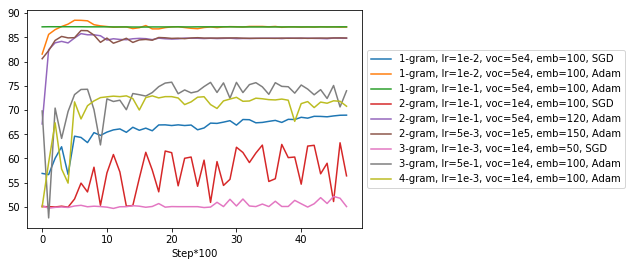

In [143]:
plt.plot(range(48), p1, label = '1-gram, lr=1e-2, voc=5e4, emb=100, SGD')
plt.plot(range(48), p2, label = '1-gram, lr=1e-2, voc=5e4, emb=100, Adam')
plt.plot(range(48), p3, label = '1-gram, lr=1e-1, voc=5e4, emb=100, Adam')
plt.plot(range(48), p4, label = '2-gram, lr=1e-1, voc=1e4, emb=100, SGD')
plt.plot(range(48), p5, label = '2-gram, lr=1e-1, voc=5e4, emb=120, Adam')
plt.plot(range(48), p6, label = '2-gram, lr=5e-3, voc=1e5, emb=150, Adam')
plt.plot(range(48), p7, label = '3-gram, lr=1e-3, voc=1e4, emb=50, SGD')
plt.plot(range(48), p8, label = '3-gram, lr=5e-1, voc=1e4, emb=100, Adam')
plt.plot(range(48), p9, label = '4-gram, lr=1e-3, voc=1e4, emb=100, Adam')
plt.xlabel('Step*100')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [144]:
p8[-1]

73.96